In [25]:
import os
from pathlib import Path

import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


# Utils

In [26]:
def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp


def plot_point_cloud(pts, title='Point Cloud'):
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

# Generate

Number of points in simplex grid with N=20: 231


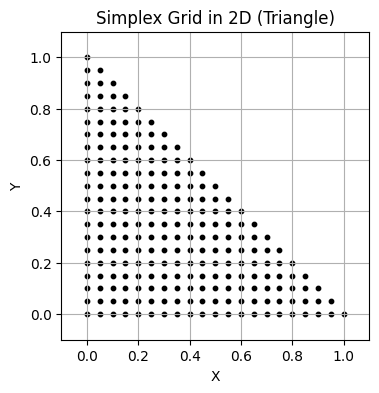

In [27]:
# ----------------------------------------------
# Generate simplex grid --> triangle (3 templates)
# ---------------------------------------------- 
N = 20
pts = []
for l in range(N + 1):
    for j in range(N + 1 - l):
        k = N - l - j
        pts.append((l / N, j / N, k / N))
pts=np.array(pts)

print('Number of points in simplex grid with N={}: {}'.format(N, pts.shape[0]))

plot_point_cloud(pts[:, :2], title='Simplex Grid in 2D (Triangle)')

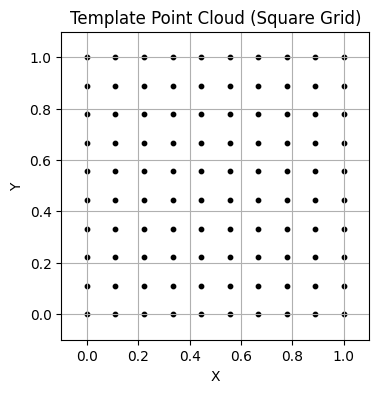

In [28]:
# ----------------------------------------------
# Generate a template cloud point in 2D that is a uniform grid in a square
# ----------------------------------------------
n_pts_per_side = 10
x = np.linspace(0, 1, n_pts_per_side)
y = np.linspace(0, 1, n_pts_per_side)
X, Y = np.meshgrid(x, y)
template_pts = np.vstack([X.ravel(), Y.ravel()]).T  # shape (n_pts_per_side**2, 2)          

plot_point_cloud(template_pts, title='Template Point Cloud (Square Grid)')
 

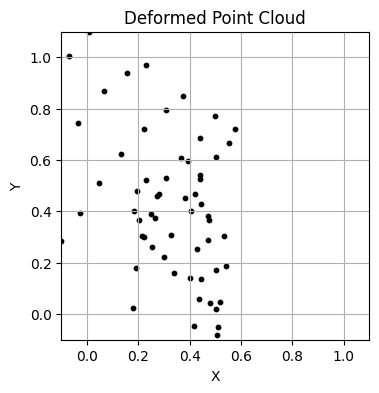

In [ ]:
# -----------------------------------------------
# Example: Generate a random deformation of the template cloud
# -----------------------------------------------
deformed_pts, disp, ctrl_pts, ctrl_disp = random_rbf_deformation(
    template_pts,
    num_ctrl=15,
    sigma=0.2,
    max_disp=1,
)

plot_point_cloud(deformed_pts, title='Deformed Point Cloud')
